# Project Papadias

# A. Choose a data set of a quantity whose weekly values (e.g. closing price of a stock index every Monday) over 5 years are available. Go over this data set and make sure to clean it up of any inconsistencies, outliers, missing data, etc.

## Importing Libraries

In [18]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing
#from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
#from sklearn.model_selection import TimeSeriesSplit
#import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Getting the stock price data for APPLE

In [19]:
# Ticker symbol for company that we want to find (e.g., 'AAPL' for Apple Inc.)
ticker_symbol = 'AAPL'

# Time Period Interval
start_time = '2017-01-01'
end_time = '2021-12-31'

stock_data = yf.download(ticker_symbol, start=start_time, end=end_time)

csv_file_path = 'stock_data.csv'
stock_data.to_csv(csv_file_path)
print(f'Stock data has been saved to {csv_file_path}')

[*********************100%%**********************]  1 of 1 completed
Stock data has been saved to stock_data.csv


### Separating into weekly & Preprocessing/Cleaning

In [20]:
file_path = 'stock_data.csv'
stock_data = pd.read_csv(file_path, index_col='Date', parse_dates=True)

weekly_data = stock_data.resample('W-FRI').agg({'Adj Close': 'last'})

# Check for missing values
cleaned_weekly_data = weekly_data.dropna()

# Drop duplicates
cleaned_weekly_data = weekly_data.drop_duplicates()

# Z-score for outlier detection
z_scores = np.abs(stats.zscore(cleaned_weekly_data['Adj Close']))
outlier_threshold = 3
outlier_indices = np.where(z_scores > outlier_threshold)
outliers = cleaned_weekly_data.iloc[outlier_indices]

print(f'Outliers:{outliers}')
print('\n')
print(cleaned_weekly_data.head())

#Saving to csv
csv_file_path = 'stock_data.csv'
cleaned_weekly_data.to_csv(csv_file_path)

# Seperate data into train and test datasets
train_train = cleaned_weekly_data[cleaned_weekly_data.index.year < 2020]
train_validation = cleaned_weekly_data[cleaned_weekly_data.index.year == 2020]
train = cleaned_weekly_data[cleaned_weekly_data.index.year < 2021]
test = cleaned_weekly_data[cleaned_weekly_data.index.year == 2021]

Outliers:Empty DataFrame
Columns: [Adj Close]
Index: []


            Adj Close
Date                 
2017-01-06  27.433189
2017-01-13  27.696102
2017-01-20  27.919451
2017-01-27  28.373148
2017-02-03  30.032024


In [21]:
cleaned_weekly_data

,Adj Close
Date,
2017-01-06,27.433189
2017-01-13,27.696102
2017-01-20,27.919451
2017-01-27,28.373148
2017-02-03,30.032024
...,...
2021-12-03,160.011734
2021-12-10,177.422821
2021-12-17,169.206680


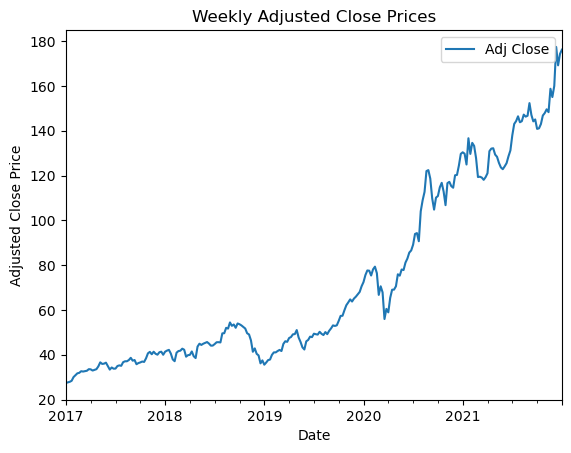

In [22]:
# Plotting the cleaned weekly data
cleaned_weekly_data.plot(title='Weekly Adjusted Close Prices')
plt.ylabel('Adjusted Close Price')
plt.show()

# B. Using the data for the first 4 years of your chosen (and cleaned up) data set, try to forecast the data of year 5. For this:

## a. Use three different forecasting techniques to perform the forecasting of level (without trend or seasonality adjustments). If a technique is parametric, try to choose the optimal value for this parameter.

## b. Compare these three techniques in two different ways.

### Naive Approach

In [23]:
def naive(actual, periods_ahead):
    naive = np.full(len(actual) + periods_ahead, np.nan)
    
    for i in range(1, len(naive)):
        if i < len(actual): 
            naive[i] = actual[i-1]
        else:
            naive[i] = actual[-1]
    return naive

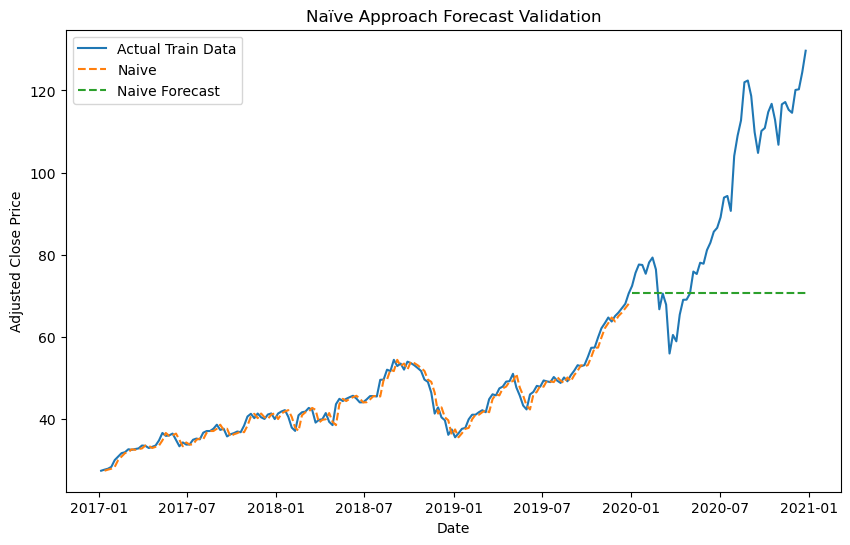

MAD: 23.93
MSE: 927.42


In [24]:
train['naive'] = naive(train_train['Adj Close'], len(train_validation))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, train['naive'][:len(train_train)], linestyle='--', label='Naive')
plt.plot(train_validation.index, train['naive'][-len(train_validation):], linestyle='--', label='Naive Forecast')
plt.title('Naïve Approach Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(train_validation['Adj Close'] - train['naive'][-len(train_validation):]))
mse = np.mean(np.square(train_validation['Adj Close'] - train['naive'][-len(train_validation):]))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

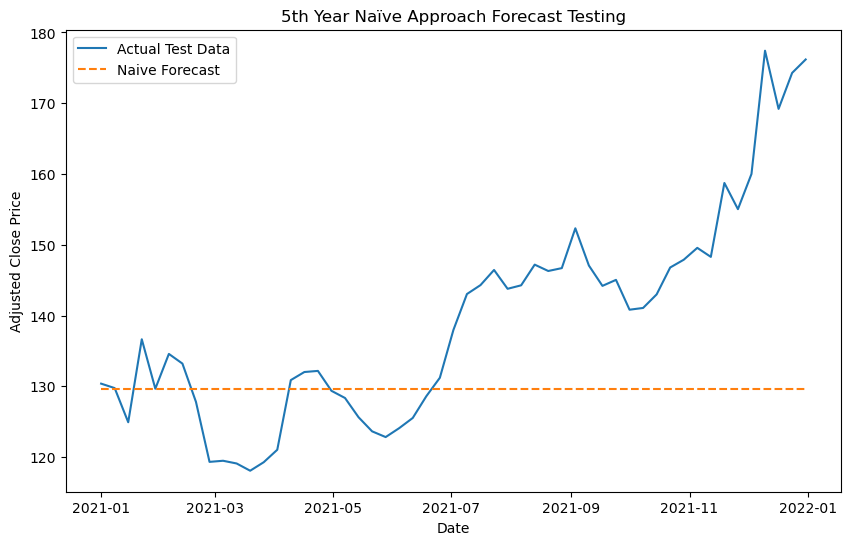

MAD: 13.16
MSE: 309.61


In [25]:
test['naive'] = naive(train['Adj Close'], len(test))[-len(test):]

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, test['naive'], linestyle='--', label='Naive Forecast')
plt.title('5th Year Naïve Approach Forecast Testing')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(test['Adj Close'] - test['naive']))
mse = np.mean(np.square(test['Adj Close'] - test['naive']))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

### Moving Average

In [26]:
def moving_avg(actual, periods_ahead, window):
    moving_avg = np.full(len(actual) + periods_ahead, np.nan)
    temp = actual
    
    for i in range(1, len(moving_avg)):
        if i < window:    
            moving_avg[i] = np.mean(temp[0:i])
            if i >= len(actual):
                temp = np.append(temp, moving_avg[i])
        else:
            moving_avg[i] = np.mean(temp[i-window:i])
            if i >= len(actual):
                temp = np.append(temp, moving_avg[i])
    return moving_avg

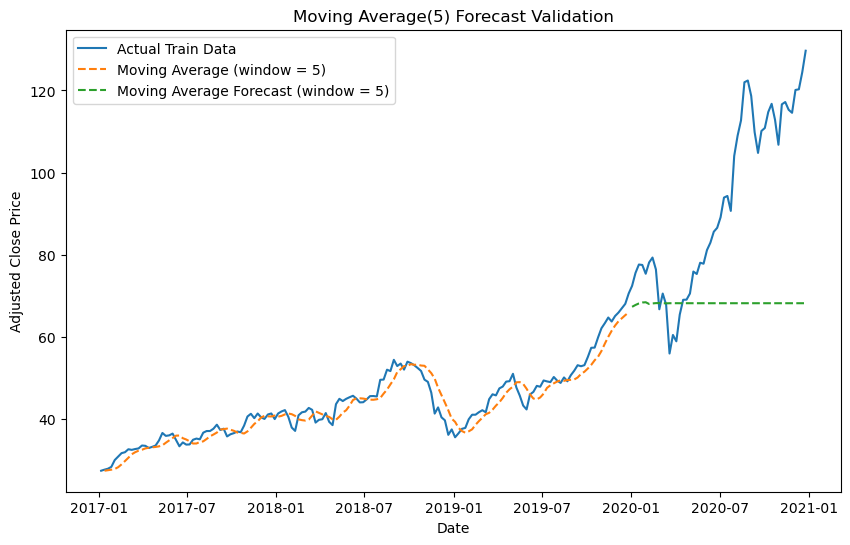

In [27]:
train['moving_avg(5)'] = moving_avg(train_train['Adj Close'], len(train_validation), 5)

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, train['moving_avg(5)'][:len(train_train)], linestyle='--', label='Moving Average (window = 5)')
plt.plot(train_validation.index, train['moving_avg(5)'][-len(train_validation):], linestyle='--', label='Moving Average Forecast (window = 5)')
plt.title('Moving Average(5) Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

In [28]:
moving_avg_window_metrics = pd.DataFrame(columns=['window', 'mad', 'mse'])

for window in range(2, len(train_train)):
    mad = np.mean(np.abs(train_validation['Adj Close'] - moving_avg(train_train['Adj Close'], len(train_validation), window)[-len(train_validation):]))
    mse = np.mean(np.square(train_validation['Adj Close'] - moving_avg(train_train['Adj Close'], len(train_validation), window)[-len(train_validation):]))
    new_row = pd.DataFrame({'window': [window], 'mad': [mad], 'mse': [mse]})
    moving_avg_window_metrics = pd.concat([moving_avg_window_metrics, new_row], ignore_index=True)

min_mad = moving_avg_window_metrics['mad'].min()
min_mad_row = moving_avg_window_metrics.loc[moving_avg_window_metrics['mad'].idxmin()]
min_mad_window = min_mad_row['window']
min_mse = moving_avg_window_metrics['mse'].min()
min_mse_row = moving_avg_window_metrics.loc[moving_avg_window_metrics['mse'].idxmin()]
min_mse_window = min_mse_row['window']

print(f'Minimum MAD ({min_mad:.2f}) achieved with window size of {min_mad_window}')
print(f'Minimum MSE ({min_mse:.2f}) achieved with window size of {min_mse_window}')

Minimum MAD (24.52) achieved with window size of 2
Minimum MSE (965.09) achieved with window size of 2


In [41]:
len(train_train)

156

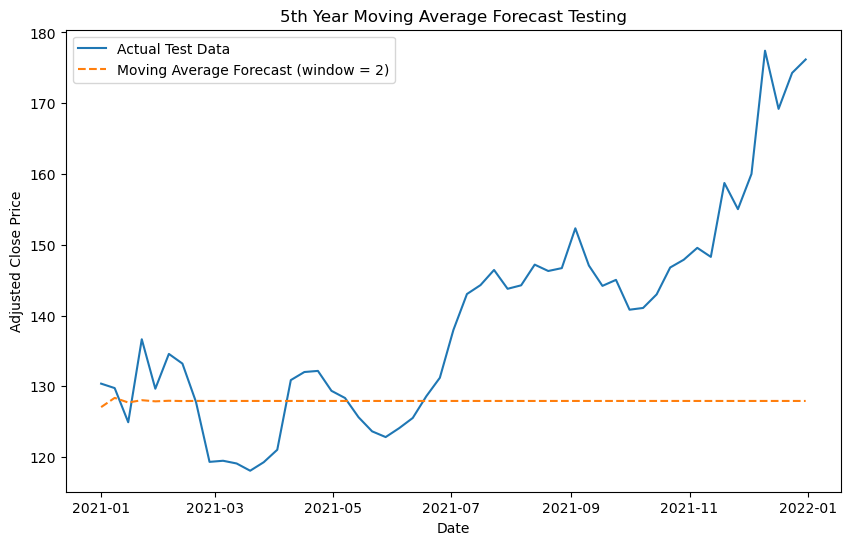

MAD: 13.94
MSE: 345.58


In [29]:
test['moving_avg(2)'] = moving_avg(train['Adj Close'], len(test), 2)[-len(test):]

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, test['moving_avg(2)'], linestyle='--', label='Moving Average Forecast (window = 2)')
plt.title('5th Year Moving Average Forecast Testing')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(test['Adj Close'] - test['moving_avg(2)']))
mse = np.mean(np.square(test['Adj Close'] - test['moving_avg(2)']))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

### Exponential Smoothing

In [30]:
def exp_smooth(actual, periods_ahead, a):
    exp_smooth = np.full(len(actual) + periods_ahead, np.nan)
    exp_smooth[0] = actual[0]
    temp = actual
    
    for i in range(1, len(exp_smooth)):
        exp_smooth[i] = a * temp[i-1] + (1 - a) * exp_smooth[i-1]
        if i >= len(actual):
            temp = np.append(temp, exp_smooth[i])
    return exp_smooth

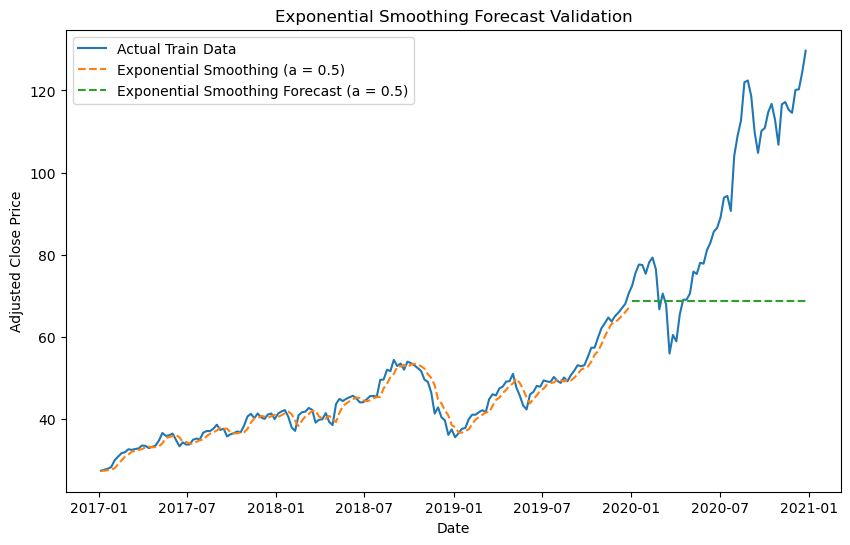

In [31]:
train['exp_smooth(0.5)'] = exp_smooth(train_train['Adj Close'], len(train_validation), 0.5)

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, train['exp_smooth(0.5)'][:len(train_train)], linestyle='--', label='Exponential Smoothing (a = 0.5)')
plt.plot(train_validation.index, train['exp_smooth(0.5)'][-len(train_validation):], linestyle='--', label='Exponential Smoothing Forecast (a = 0.5)')
plt.title('Exponential Smoothing Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

In [32]:
exp_smooth_a_metrics = pd.DataFrame(columns=['a', 'mad', 'mse'])

for a in np.arange(0.01, 1, 0.01):
    mad = np.mean(np.abs(train_validation['Adj Close'] - exp_smooth(train_train['Adj Close'], len(train_validation), a)[-len(train_validation):]))
    mse = np.mean(np.square(train_validation['Adj Close'] - exp_smooth(train_train['Adj Close'], len(train_validation), a)[-len(train_validation):]))
    new_row = pd.DataFrame({'a': [a], 'mad': [mad], 'mse': [mse]})
    exp_smooth_a_metrics = pd.concat([exp_smooth_a_metrics, new_row], ignore_index=True)

min_mad = exp_smooth_a_metrics['mad'].min()
min_mad_row = exp_smooth_a_metrics.loc[exp_smooth_a_metrics['mad'].idxmin()]
min_mad_a = min_mad_row['a']
min_mse = exp_smooth_a_metrics['mse'].min()
min_mse_row = exp_smooth_a_metrics.loc[exp_smooth_a_metrics['mse'].idxmin()]
min_mse_a = min_mse_row['a']

print(f'Minimum MAD ({min_mad:.2f}) achieved with a = {min_mad_a}')
print(f'Minimum MSE ({min_mse:.2f}) achieved with a = {min_mse_a}')

Minimum MAD (23.95) achieved with a = 0.99
Minimum MSE (928.53) achieved with a = 0.99


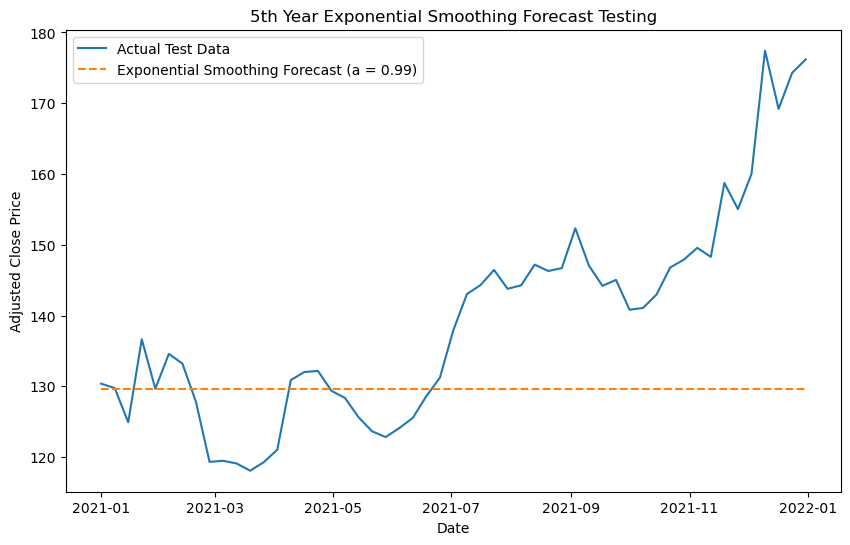

MAD: 13.18
MSE: 310.61


In [33]:
test['exp_smooth(0.99)'] = exp_smooth(train['Adj Close'], len(test), 0.99)[-len(test):]

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, test['exp_smooth(0.99)'], linestyle='--', label='Exponential Smoothing Forecast (a = 0.99)')
plt.title('5th Year Exponential Smoothing Forecast Testing')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(test['Adj Close'] - test['exp_smooth(0.99)']))
mse = np.mean(np.square(test['Adj Close'] - test['exp_smooth(0.99)']))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

## C (using ExponentialSmoothing function)

In [34]:
model = ExponentialSmoothing(train_train['Adj Close'], trend='add')
exp_smooth_trend_metrics = pd.DataFrame(columns=['a', 'b', 'mad', 'mse'])

for a in np.arange(0.01, 1, 0.01):
    for b in np.arange(0.01, 1, 0.01):
        result = model.fit(smoothing_level=a, smoothing_trend=b)
        forecast = result.forecast(len(train_validation))
        mad = np.mean(np.abs(train_validation['Adj Close'] - forecast))
        mse = np.mean(np.square(train_validation['Adj Close'] - forecast))
        new_row = pd.DataFrame({'a': [a], 'b': [b], 'mad': [mad], 'mse': [mse]})
        exp_smooth_trend_metrics = pd.concat([exp_smooth_trend_metrics, new_row], ignore_index=True)

min_mad = exp_smooth_trend_metrics['mad'].min()
min_mad_row = exp_smooth_trend_metrics.loc[exp_smooth_trend_metrics['mad'].idxmin()]
min_mad_a = min_mad_row['a']
min_mad_b = min_mad_row['b']
min_mse = exp_smooth_trend_metrics['mse'].min()
min_mse_row = exp_smooth_trend_metrics.loc[exp_smooth_trend_metrics['mse'].idxmin()]
min_mse_a = min_mse_row['a']
min_mse_b = min_mse_row['b']

print(f'Minimum MAD ({min_mad:.2f}) achieved with a = {min_mad_a} and b = {min_mad_b}')
print(f'Minimum MSE ({min_mse:.2f}) achieved with a = {min_mse_a} and b = {min_mse_b}')

Minimum MAD (7.48) achieved with a = 0.01 and b = 0.53
Minimum MSE (86.68) achieved with a = 0.03 and b = 0.77


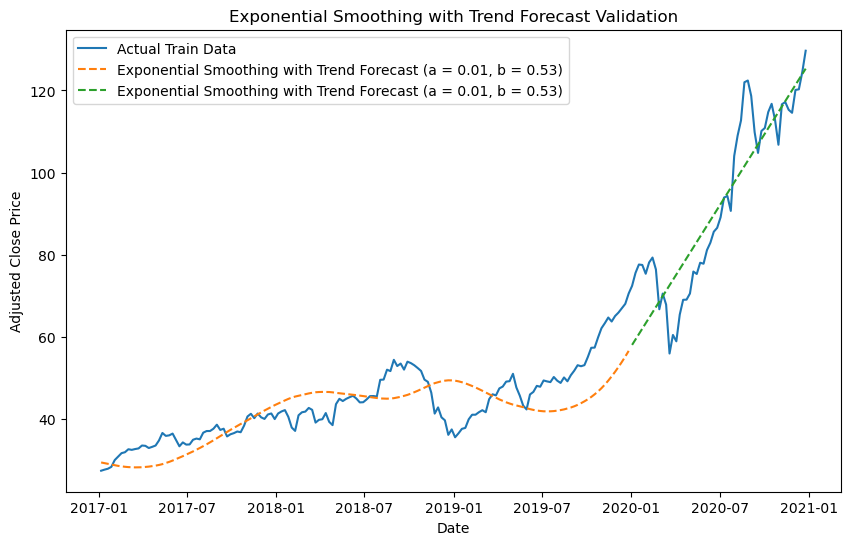

MAD: 7.48
MSE: 87.81


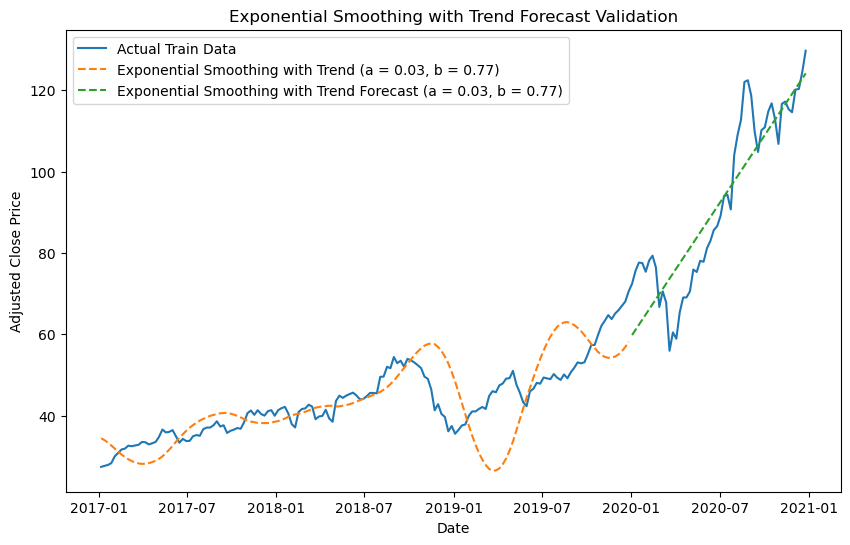

MAD: 7.52
MSE: 86.68


In [35]:
result = model.fit(smoothing_level=0.01, smoothing_trend=0.53)
forecast = result.forecast(len(train_validation))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, result.fittedvalues, linestyle='--', label='Exponential Smoothing with Trend Forecast (a = 0.01, b = 0.53)')
plt.plot(train_validation.index, forecast, linestyle='--', label='Exponential Smoothing with Trend Forecast (a = 0.01, b = 0.53)')
plt.title('Exponential Smoothing with Trend Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(train_validation['Adj Close'] - forecast))
mse = np.mean(np.square(train_validation['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

result = model.fit(smoothing_level=0.03, smoothing_trend=0.77)
forecast = result.forecast(len(train_validation))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, result.fittedvalues, linestyle='--', label='Exponential Smoothing with Trend (a = 0.03, b = 0.77)')
plt.plot(train_validation.index, forecast, linestyle='--', label='Exponential Smoothing with Trend Forecast (a = 0.03, b = 0.77)')
plt.title('Exponential Smoothing with Trend Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(train_validation['Adj Close'] - forecast))
mse = np.mean(np.square(train_validation['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

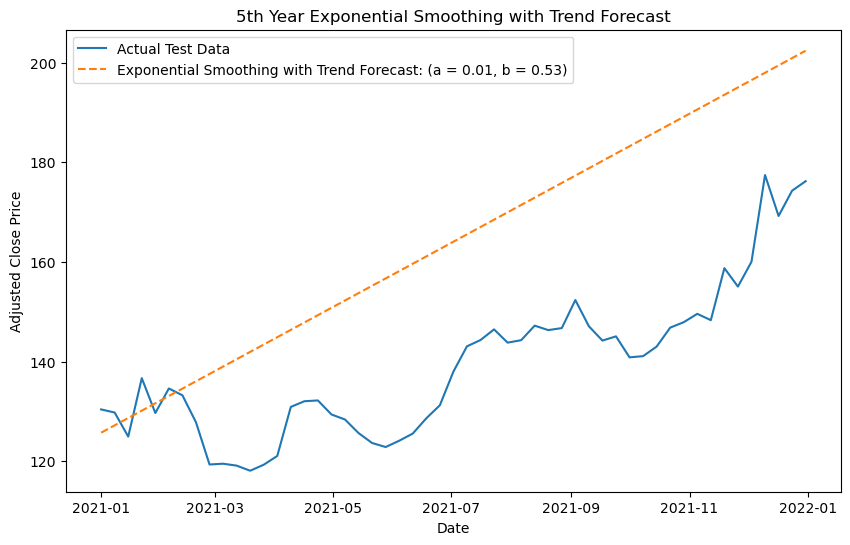

MAD: 25.47
MSE: 786.85


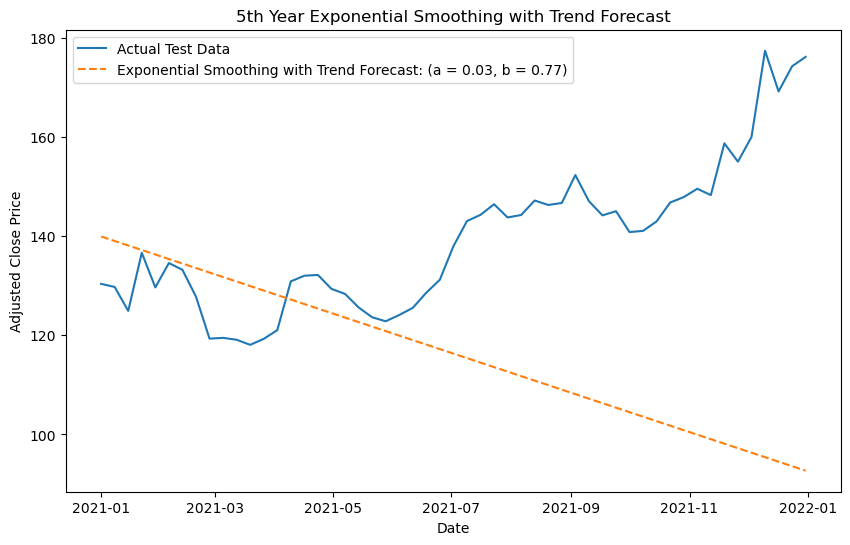

MAD: 27.10
MSE: 1280.73


In [36]:
model = ExponentialSmoothing(train['Adj Close'], trend='add')
result = model.fit(smoothing_level=0.01, smoothing_trend=0.53)
forecast = result.forecast(len(test))

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, forecast, linestyle='--', label='Exponential Smoothing with Trend Forecast: (a = 0.01, b = 0.53)')
plt.title('5th Year Exponential Smoothing with Trend Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(test['Adj Close'] - forecast))
mse = np.mean(np.square(test['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

result = model.fit(smoothing_level=0.03, smoothing_trend=0.77)
forecast = result.forecast(len(test))

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, forecast, linestyle='--', label='Exponential Smoothing with Trend Forecast: (a = 0.03, b = 0.77)')
plt.title('5th Year Exponential Smoothing with Trend Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(test['Adj Close'] - forecast))
mse = np.mean(np.square(test['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

## C (custom way)

In [58]:
def exp_smooth_trend(actual, periods_ahead, a, b):
    exp_smooth = np.full(len(actual) + periods_ahead, np.nan)
    exp_smooth[0] = actual[0]
    trend = np.full(len(actual) + periods_ahead, np.nan)
    trend[0] = 0
    exp_smooth_trend = np.full(len(actual) + periods_ahead, np.nan)
    exp_smooth_trend[0] = actual[0]
    temp = actual
    
    for i in range(1, len(exp_smooth_trend)):
#        if i < len(actual):
#            exp_smooth[i] = a * actual[i-1] + (1 - a) * (exp_smooth[i-1] - trend[i-1])
#        else:
#        exp_smooth[i] = exp_smooth[i-1] + (i - len(actual) + 1) * trend[i-1]
        exp_smooth[i] = a * temp[i-1] + (1 - a) * (exp_smooth[i-1] - trend[i-1])
        trend[i] = b * (exp_smooth[i] - exp_smooth[i-1]) + (1 - b) * trend[i-1]
        exp_smooth_trend[i] = exp_smooth[i] + trend[i]
        if i >= len(actual):
            temp = np.append(temp, exp_smooth_trend[i])
    return exp_smooth_trend

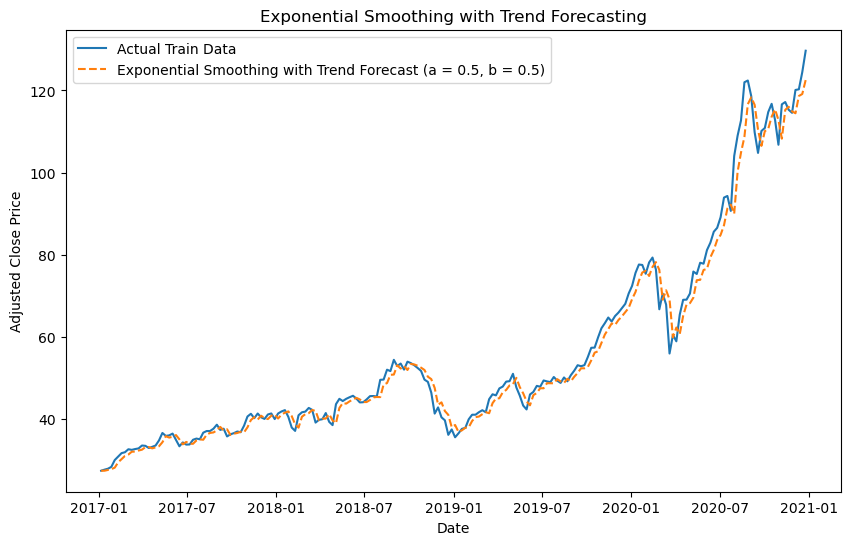

In [60]:
train['exp_smooth_trend(0.5, 0.5)'] = exp_smooth_trend(train['Adj Close'], 0, 0.5, 0.5)

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train.index, train['exp_smooth_trend(0.5, 0.5)'], linestyle='--', label='Exponential Smoothing with Trend Forecast (a = 0.5, b = 0.5)')
plt.title('Exponential Smoothing with Trend Forecasting')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

In [61]:
exp_smooth_trend_metrics = pd.DataFrame(columns=['a', 'b', 'mad', 'mse'])

for a in np.arange(0.01, 1, 0.01):
    for b in np.arange(0.01, 1, 0.01):
        mad = np.mean(np.abs(train['Adj Close'][1:] - exp_smooth_trend(train['Adj Close'][1:], 0, a, b)))
        mse = np.mean(np.square(train['Adj Close'][1:] - exp_smooth_trend(train['Adj Close'][1:], 0, a, b)))
        new_row = pd.DataFrame({'a': [a], 'b': [b], 'mad': [mad], 'mse': [mse]})
        exp_smooth_trend_metrics = pd.concat([exp_smooth_trend_metrics, new_row], ignore_index=True)

min_mad = exp_smooth_trend_metrics['mad'].min()
min_mad_row = exp_smooth_trend_metrics.loc[exp_smooth_trend_metrics['mad'].idxmin()]
min_mad_a = min_mad_row['a']
min_mad_b = min_mad_row['b']
min_mse = exp_smooth_trend_metrics['mse'].min()
min_mse_row = exp_smooth_trend_metrics.loc[exp_smooth_trend_metrics['mse'].idxmin()]
min_mse_a = min_mse_row['a']
min_mse_b = min_mse_row['b']

print(f'Minimum MAD ({min_mad:.2f}) achieved with a = {min_mad_a} and b = {min_mad_b}')
print(f'Minimum MSE ({min_mse:.2f}) achieved with a = {min_mse_a} and b = {min_mse_b}')

Minimum MAD (1.71) achieved with a = 0.9500000000000001 and b = 0.11
Minimum MSE (7.10) achieved with a = 0.99 and b = 0.02


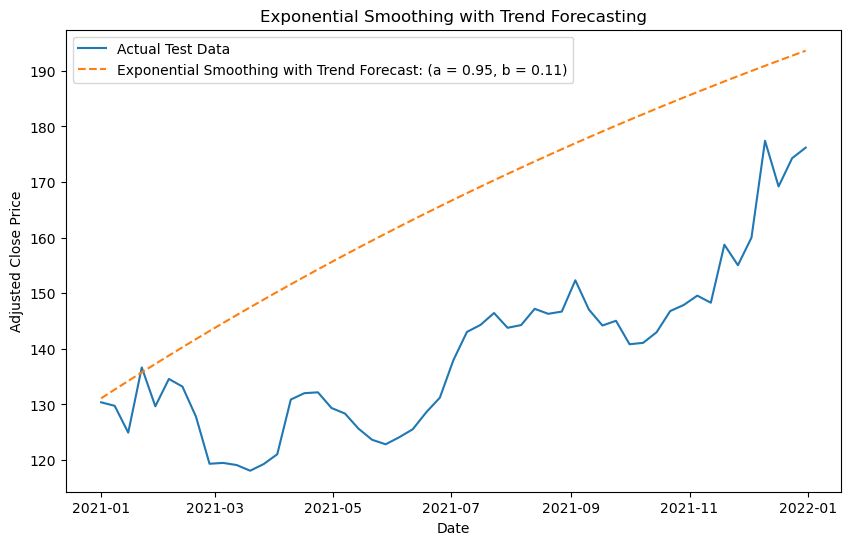

MAD: 26.17
MSE: 798.67


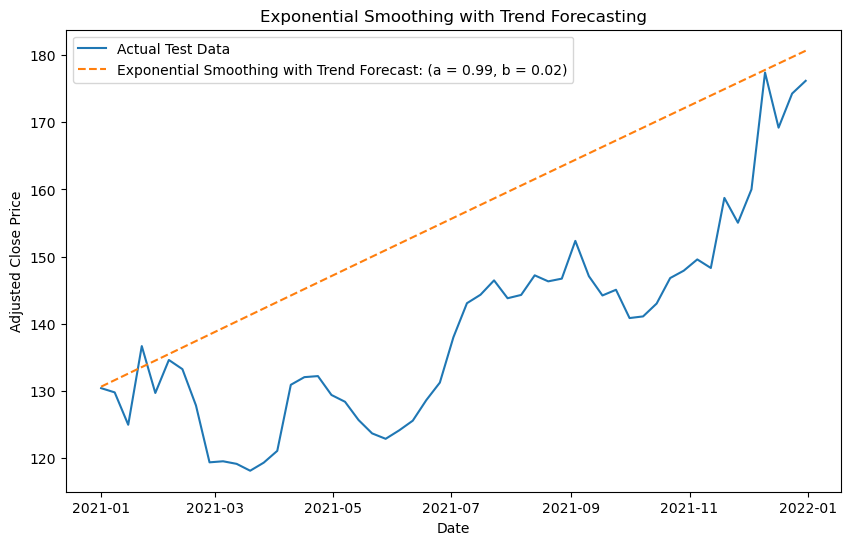

MAD: 16.70
MSE: 345.49


In [63]:
test['exp_smooth_trend(0.95, 0.11)'] = exp_smooth_trend(train['Adj Close'], len(test), 0.95, 0.11)[-len(test):]

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, test['exp_smooth_trend(0.95, 0.11)'], linestyle='--', label='Exponential Smoothing with Trend Forecast: (a = 0.95, b = 0.11)')
plt.title('Exponential Smoothing with Trend Forecasting')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(test['Adj Close'] - test['exp_smooth_trend(0.95, 0.11)']))
mse = np.mean(np.square(test['Adj Close'] - test['exp_smooth_trend(0.95, 0.11)']))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

test['exp_smooth_trend(0.99, 0.02)'] = exp_smooth_trend(train['Adj Close'], len(test), 0.99, 0.02)[-len(test):]

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, test['exp_smooth_trend(0.99, 0.02)'], linestyle='--', label='Exponential Smoothing with Trend Forecast: (a = 0.99, b = 0.02)')
plt.title('Exponential Smoothing with Trend Forecasting')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(test['Adj Close'] - test['exp_smooth_trend(0.99, 0.02)']))
mse = np.mean(np.square(test['Adj Close'] - test['exp_smooth_trend(0.99, 0.02)']))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

## D (using ExponentialSmoothing function)

## This one takes a long time to run (skip it)

In [37]:
model = ExponentialSmoothing(train_train['Adj Close'], trend='add', seasonal='add', seasonal_periods=52)
exp_smooth_season_metrics = pd.DataFrame(columns=['a', 'b', 'g', 'mad', 'mse'])

for a in np.arange(0.01, 1, 0.01):
    for b in np.arange(0.01, 1, 0.01):
        for g in np.arange(0.01, 1, 0.01):
            result = model.fit(smoothing_level=a, smoothing_trend=b, smoothing_seasonal=g)
            forecast = result.forecast(len(train_validation))
            mad = np.mean(np.abs(train_validation['Adj Close'] - forecast))
            mse = np.mean(np.square(train_validation['Adj Close'] - forecast))
            new_row = pd.DataFrame({'a': [a], 'b': [b], 'g': [g], 'mad': [mad], 'mse': [mse]})
            exp_smooth_season_metrics = pd.concat([exp_smooth_season_metrics, new_row], ignore_index=True)

min_mad = exp_smooth_trend_metrics['mad'].min()
min_mad_row = exp_smooth_season_metrics.loc[exp_smooth_season_metrics['mad'].idxmin()]
min_mad_a = min_mad_row['a']
min_mad_b = min_mad_row['b']
min_mad_g = min_mad_row['g']
min_mse = exp_smooth_trend_metrics['mse'].min()
min_mse_row = exp_smooth_season_metrics.loc[exp_smooth_season_metrics['mse'].idxmin()]
min_mse_a = min_mse_row['a']
min_mse_b = min_mse_row['b']
min_mse_g = min_mse_row['g']

print(f'Minimum MAD ({min_mad:.2f}) achieved with a = {min_mad_a} and b = {min_mad_b} and g = {min_mad_g}')
print(f'Minimum MSE ({min_mse:.2f}) achieved with a = {min_mse_a} and b = {min_mse_b} and g = {min_mse_g}')

Minimum MAD (7.48) achieved with a = 0.02 and b = 0.32 and g = 0.01
Minimum MSE (86.68) achieved with a = 0.06 and b = 0.16 and g = 0.02


In [38]:
print(f'Minimum MAD ({min_mad:.2f}) achieved with a = {min_mad_a} and b = {min_mad_b} and g = {min_mad_g}')
print(f'Minimum MSE ({min_mse:.2f}) achieved with a = {min_mse_a} and b = {min_mse_b} and g = {min_mse_g}')

Minimum MAD (7.48) achieved with a = 0.02 and b = 0.32 and g = 0.01
Minimum MSE (86.68) achieved with a = 0.06 and b = 0.16 and g = 0.02


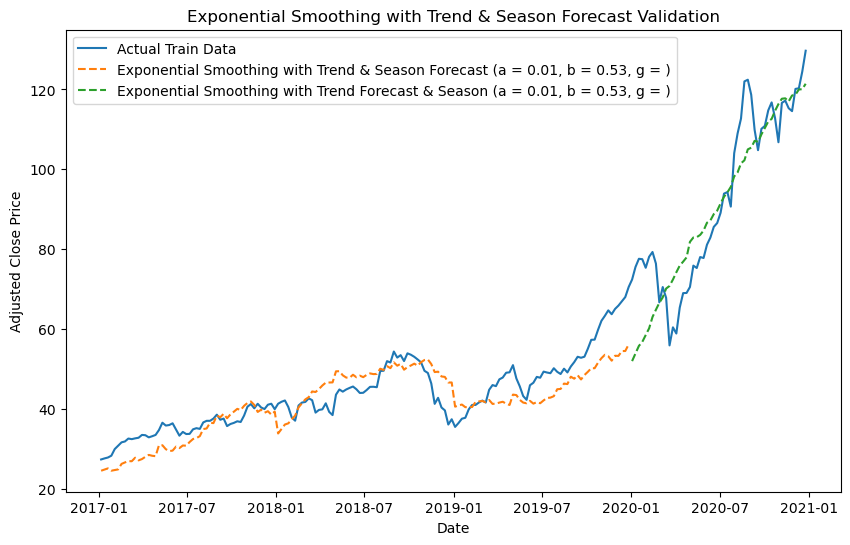

MAD: 7.85
MSE: 104.41


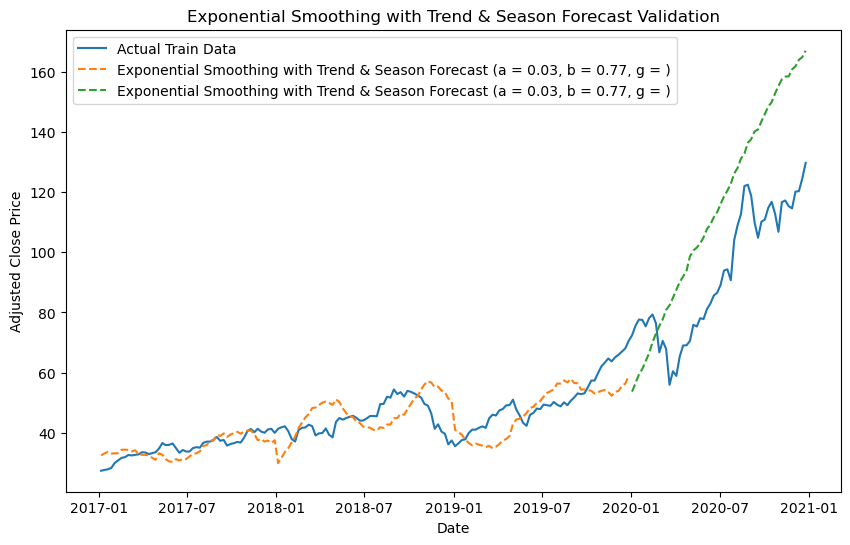

MAD: 26.19
MSE: 801.04


In [39]:
result = model.fit(smoothing_level=0.01, smoothing_trend=0.59, smoothing_seasonal=0.02)
forecast = result.forecast(len(train_validation))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, result.fittedvalues, linestyle='--', label='Exponential Smoothing with Trend & Season Forecast (a = 0.01, b = 0.53, g = )')
plt.plot(train_validation.index, forecast, linestyle='--', label='Exponential Smoothing with Trend Forecast & Season (a = 0.01, b = 0.53, g = )')
plt.title('Exponential Smoothing with Trend & Season Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(train_validation['Adj Close'] - forecast))
mse = np.mean(np.square(train_validation['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

result = model.fit(smoothing_level=0.03, smoothing_trend=0.77, smoothing_seasonal=0.029)
forecast = result.forecast(len(train_validation))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Actual Train Data')
plt.plot(train_train.index, result.fittedvalues, linestyle='--', label='Exponential Smoothing with Trend & Season Forecast (a = 0.03, b = 0.77, g = )')
plt.plot(train_validation.index, forecast, linestyle='--', label='Exponential Smoothing with Trend & Season Forecast (a = 0.03, b = 0.77, g = )')
plt.title('Exponential Smoothing with Trend & Season Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(train_validation['Adj Close'] - forecast))
mse = np.mean(np.square(train_validation['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

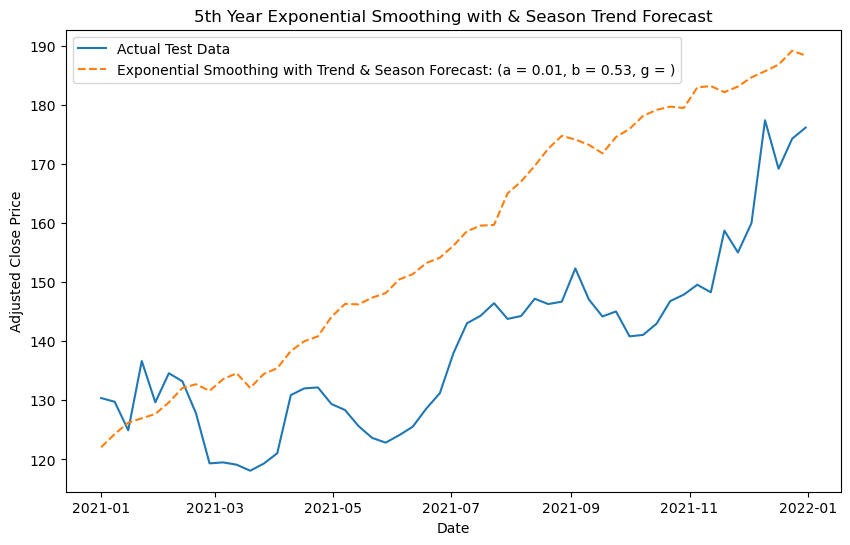

MAD: 19.03
MSE: 454.80


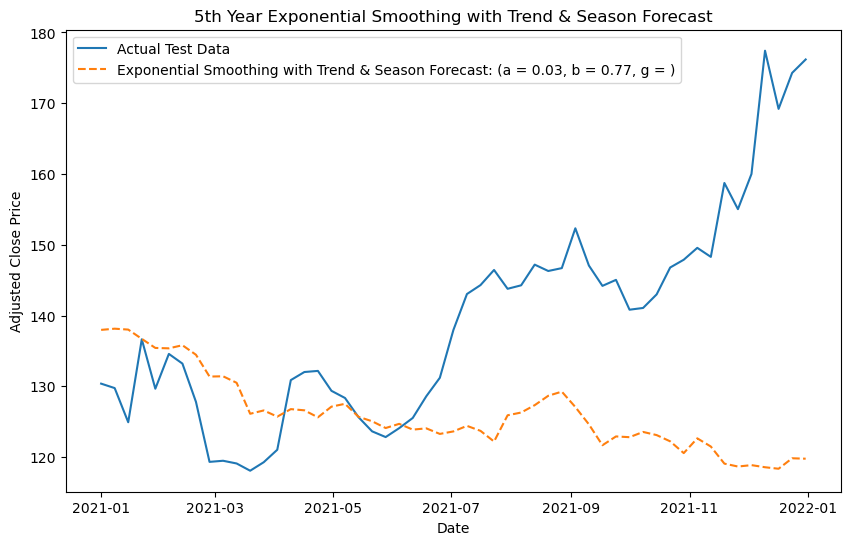

MAD: 16.92
MSE: 510.93


In [40]:
model = ExponentialSmoothing(train['Adj Close'], trend='add', seasonal='add', seasonal_periods=52)
result = model.fit(smoothing_level=0.01, smoothing_trend=0.53, smoothing_seasonal=0.029)
forecast = result.forecast(len(test))

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, forecast, linestyle='--', label='Exponential Smoothing with Trend & Season Forecast: (a = 0.01, b = 0.53, g = )')
plt.title('5th Year Exponential Smoothing with & Season Trend Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(test['Adj Close'] - forecast))
mse = np.mean(np.square(test['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

result = model.fit(smoothing_level=0.03, smoothing_trend=0.77, smoothing_seasonal=0.029)
forecast = result.forecast(len(test))

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Adj Close'], label='Actual Test Data')
plt.plot(test.index, forecast, linestyle='--', label='Exponential Smoothing with Trend & Season Forecast: (a = 0.03, b = 0.77, g = )')
plt.title('5th Year Exponential Smoothing with Trend & Season Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

mad = np.mean(np.abs(test['Adj Close'] - forecast))
mse = np.mean(np.square(test['Adj Close'] - forecast))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

In [2]:
# Microsoft Corporation - MSFT
# Amazon.com, Inc. - AMZN
# Google (Alphabet Inc.) - GOOGL
# Facebook (Meta Platforms, Inc.) - META
# Tesla, Inc. - TSLA
# Berkshire Hathaway Inc. - BRK-B
# Johnson & Johnson - JNJ
# JPMorgan Chase & Co. - JPM
# Visa Inc. - V
# Coca-Cola - KO
 
ticker_symbols = ['MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'BRK-B', 'JNJ', 'JPM', 'V','KO']
 
start_time = '2017-01-01'
end_time = '2020-12-31'
 
# Create a dictionary to store dataframes
stock_dataframes = {}
 
for ticker in ticker_symbols:
    # Downloading stock data
    stock_data = yf.download(ticker, start=start_time, end=end_time)
    # Resample to monthly data and use the last available data of the month
    monthly_data = stock_data['Adj Close'].resample('M').last()
    # Store in the dictionary
    stock_dataframes[ticker] = monthly_data
 
# Adding Apple's stock data to the dictionary
aapl_data = yf.download('AAPL', start=start_time, end='2021-12-31')
monthly_aapl_data = aapl_data['Adj Close'].resample('M').last()

stock_dataframes['KO']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Date
2017-01-31    33.254906
2017-02-28    33.566902
2017-03-31    34.250553
2017-04-30    34.823544
2017-05-31    36.695866
2017-06-30    36.493378
2017-07-31    37.298920
2017-08-31    37.062954
2017-09-30    36.914978
2017-10-31    37.710522
2017-11-30    37.846054
2017-12-31    37.937012
2018-01-31    39.350964
2018-02-28    35.737522
2018-03-31    36.228184
2018-04-30    36.044647
2018-05-31    35.869488
2018-06-30    36.912716
2018-07-31    39.243961
2018-08-31    37.510254
2018-09-30    39.204300
2018-10-31    40.638721
2018-11-30    43.115868
2018-12-31    40.506668
2019-01-31    41.173946
2019-02-28    38.787170
2019-03-31    40.437435
2019-04-30    42.335911
2019-05-31    42.396313
2019-06-30    44.284000
2019-07-31    45.771152
2019-08-31    47.867077
2019-09-30    47.691425
2019-10-31    47.682663
2019-11-30    47.129780
2019-12-31    48.850815
2020-01-31    51.542679
2020-02-29    47.209221
2020-03-31    39.396687
2020-04-30    40.856812
2020-05-31    41.560154
2020-06-30 

In [3]:
# Convert to DataFrame
frames = []
for symbol, series in stock_dataframes.items():
    frame = series.reset_index()
    frame['Symbol'] = symbol
    frames.append(frame)
 
result_df = pd.concat(frames)
 
# Rename columns for clarity
result_df.rename(columns={'index': 'Date', 'Adj Close': 'Adj Close'}, inplace=True)
 
print(result_df)
result_df.set_index('Symbol', inplace=True)
result_df.loc['MSFT']

         Date  Adj Close Symbol
0  2017-01-31  59.028744   MSFT
1  2017-02-28  58.771156   MSFT
2  2017-03-31  60.498093   MSFT
3  2017-04-30  62.886429   MSFT
4  2017-05-31  64.521797   MSFT
..        ...        ...    ...
43 2020-08-31  44.498188     KO
44 2020-09-30  44.713482     KO
45 2020-10-31  43.527046     KO
46 2020-11-30  47.099590     KO
47 2020-12-31  49.691898     KO

[480 rows x 3 columns]


,Date,Adj Close
Symbol,,
MSFT,2017-01-31,59.028744
MSFT,2017-02-28,58.771156
MSFT,2017-03-31,60.498093
MSFT,2017-04-30,62.886429
MSFT,2017-05-31,64.521797
MSFT,2017-06-30,63.681080
MSFT,2017-07-31,67.163994
MSFT,2017-08-31,69.444412
MSFT,2017-09-30,69.184341


In [4]:
af_df = pd.DataFrame(columns=['Symbol', 'Adj Close', 'Naive', 'A/F'])
for i in ticker_symbols:
    new_row = pd.DataFrame({'Symbol': [i], 'Adj Close': [result_df.loc[i]['Adj Close'][47]], 'Naive': [result_df.loc[i]['Adj Close'][46]], 'A/F': [result_df.loc[i]['Adj Close'][47]/result_df.loc[i]['Adj Close'][46]]})
    af_df = pd.concat([af_df, new_row], ignore_index=True)
    #model = ExponentialSmoothing(result_df.loc(i)['Adj Close'][:36], trend='add', seasonal='add', seasonal_periods=12)
    #result = model.fit(smoothing_level=0.01, smoothing_trend=0.53, smoothing_seasonal=0.029)
    #forecast = result.forecast(12)

In [5]:
af_mean = af_df['A/F'].mean()

In [6]:
aapl_df = monthly_aapl_data.to_frame()

In [7]:
aapl_df

,Adj Close
Date,
2017-01-31,28.233545
2017-02-28,32.010567
2017-03-31,33.569149
2017-04-30,33.566826
2017-05-31,35.842888
2017-06-30,33.792179
2017-07-31,34.897320
2017-08-31,38.631313
2017-09-30,36.304005


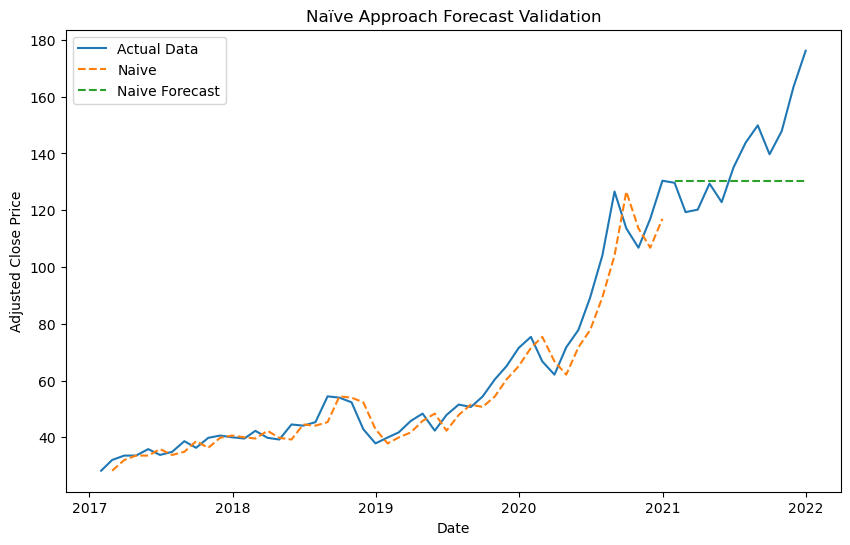

MAD: 14.48
MSE: 370.71


In [16]:
aapl_df['naive'] = naive(aapl_df['Adj Close'][:48], 12)

plt.figure(figsize=(10, 6))
plt.plot(aapl_df.index, aapl_df['Adj Close'], label='Actual Data')
plt.plot(aapl_df.index[:48], aapl_df['naive'][:48], linestyle='--', label='Naive')
plt.plot(aapl_df.index[-12:], aapl_df['naive'][-12:], linestyle='--', label='Naive Forecast')
plt.title('Naïve Approach Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(aapl_df['Adj Close'][-12:] - aapl_df['naive'][-12:]))
mse = np.mean(np.square(aapl_df['Adj Close'][-12:] - aapl_df['naive'][-12:]))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')

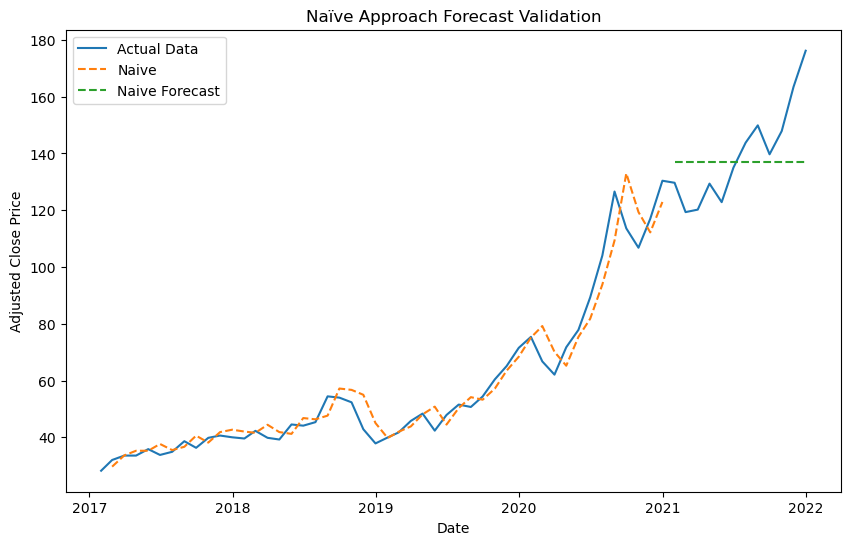

MAD: 13.70
MSE: 290.30


In [17]:
aapl_df['naive(a/f)'] = aapl_df['naive'] * af_mean

plt.figure(figsize=(10, 6))
plt.plot(aapl_df.index, aapl_df['Adj Close'], label='Actual Data')
plt.plot(aapl_df.index[:48], aapl_df['naive(a/f)'][:48], linestyle='--', label='Naive')
plt.plot(aapl_df.index[-12:], aapl_df['naive(a/f)'][-12:], linestyle='--', label='Naive Forecast')
plt.title('Naïve Approach Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Print MAD, MSE
mad = np.mean(np.abs(aapl_df['Adj Close'][-12:] - aapl_df['naive(a/f)'][-12:]))
mse = np.mean(np.square(aapl_df['Adj Close'][-12:] - aapl_df['naive(a/f)'][-12:]))

print(f'MAD: {mad:.2f}')
print(f'MSE: {mse:.2f}')